<a href="https://colab.research.google.com/github/NICHOLATE/Bias_Audit_Credit/blob/main/Bias_Audit_Credit_ipynb_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install aif360==0.5.0 scikit-learn pandas numpy seaborn matplotlib statsmodels


In [5]:
import pandas as pd

# Load training data
adult_train = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None, sep=",", skipinitialspace=True
)

# Load test data
adult_test = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
    header=None, sep=",", skipinitialspace=True, skiprows=1
)

print(adult_train.head())


   0                 1       2          3   4                   5   \
0  39         State-gov   77516  Bachelors  13       Never-married   
1  50  Self-emp-not-inc   83311  Bachelors  13  Married-civ-spouse   
2  38           Private  215646    HS-grad   9            Divorced   
3  53           Private  234721       11th   7  Married-civ-spouse   
4  28           Private  338409  Bachelors  13  Married-civ-spouse   

                  6              7      8       9     10  11  12  \
0       Adm-clerical  Not-in-family  White    Male  2174   0  40   
1    Exec-managerial        Husband  White    Male     0   0  13   
2  Handlers-cleaners  Not-in-family  White    Male     0   0  40   
3  Handlers-cleaners        Husband  Black    Male     0   0  40   
4     Prof-specialty           Wife  Black  Female     0   0  40   

              13     14  
0  United-States  <=50K  
1  United-States  <=50K  
2  United-States  <=50K  
3  United-States  <=50K  
4           Cuba  <=50K  


In [6]:
import pandas as pd

# Column names from UCI Adult dataset documentation
columns = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]

# Load training data
adult_train = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None, names=columns, sep=",", skipinitialspace=True
)

# Load test data
adult_test = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
    header=None, names=columns, sep=",", skipinitialspace=True, skiprows=1
)

print(adult_train.head())


   age         workclass  fnlwgt  education  education_num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital_status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital_gain  capital_loss  hours_per_week native_country income  
0          2174             0              40  United-States  <=50K  
1             0             0             

In [7]:
# Replace '?' with NaN
adult_train = adult_train.replace("?", pd.NA)
adult_test = adult_test.replace("?", pd.NA)

# Drop rows with missing values (simple approach)
adult_train = adult_train.dropna()
adult_test = adult_test.dropna()

print("Train shape:", adult_train.shape)
print("Test shape:", adult_test.shape)


Train shape: (30162, 15)
Test shape: (15060, 15)


In [11]:
import pandas as pd

# Column names
columns = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]

# Load
adult_train = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None, names=columns, sep=",", skipinitialspace=True
)
adult_test = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
    header=None, names=columns, sep=",", skipinitialspace=True, skiprows=1
)

# Clean missing
adult_train = adult_train.replace("?", pd.NA).dropna()
adult_test = adult_test.replace("?", pd.NA).dropna()

# Normalize income labels (train uses '>50K', test uses '>50K.' with a dot)
adult_train["income"] = adult_train["income"].str.strip().str.replace(".", "", regex=False)
adult_test["income"] = adult_test["income"].str.strip().str.replace(".", "", regex=False)

# Binary target: 1 for >50K, 0 otherwise
adult_train["income"] = (adult_train["income"] == ">50K").astype(int)
adult_test["income"] = (adult_test["income"] == ">50K").astype(int)

# Identify categorical columns
categorical_cols = [
    "workclass", "education", "marital_status", "occupation",
    "relationship", "race", "sex", "native_country"
]

# One-hot encode on the combined set to align columns
combined = pd.concat([adult_train.drop("income", axis=1), adult_test.drop("income", axis=1)], axis=0)
combined_ohe = pd.get_dummies(combined, columns=categorical_cols, drop_first=False)

# Split back to train/test
X_train_ohe = combined_ohe.iloc[:len(adult_train), :].copy()
X_test_ohe = combined_ohe.iloc[len(adult_train):, :].copy()

y_train = adult_train["income"].copy()
y_test = adult_test["income"].copy()

# Scale numeric features
from sklearn.preprocessing import StandardScaler
numeric_cols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]

scaler = StandardScaler()
X_train_ohe[numeric_cols] = scaler.fit_transform(X_train_ohe[numeric_cols])
X_test_ohe[numeric_cols] = scaler.transform(X_test_ohe[numeric_cols])

print("Train shape:", X_train_ohe.shape, "Test shape:", X_test_ohe.shape)
print("Sample columns:", X_train_ohe.columns[:10].tolist())


Train shape: (30162, 104) Test shape: (15060, 104)
Sample columns: ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week', 'workclass_Federal-gov', 'workclass_Local-gov', 'workclass_Private', 'workclass_Self-emp-inc']


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_ohe, y_train)   # or X_train_proc if you used Option B
y_pred = clf.predict(X_test_ohe)
y_prob = clf.predict_proba(X_test_ohe)[:, 1]

print("Baseline Accuracy:", accuracy_score(y_test, y_pred))
print("Baseline ROC AUC:", roc_auc_score(y_test, y_prob))


Baseline Accuracy: 0.8476095617529881
Baseline ROC AUC: 0.9033340193186143


In [14]:
# Use the original adult_test DataFrame for group labels
sex_test = adult_test["sex"]

priv_mask = (sex_test == "Male").values
unpriv_mask = (sex_test == "Female").values


In [15]:
import numpy as np

selection_rate_priv = np.mean(y_pred[priv_mask] == 1)
selection_rate_unpriv = np.mean(y_pred[unpriv_mask] == 1)
disparate_impact = selection_rate_unpriv / (selection_rate_priv + 1e-12)

print("Selection rate (Privileged):", selection_rate_priv)
print("Selection rate (Unprivileged):", selection_rate_unpriv)
print("Disparate Impact:", disparate_impact)


Selection rate (Privileged): 0.2630334088893269
Selection rate (Unprivileged): 0.07856706696519439
Disparate Impact: 0.29869615155219054


In [16]:
demographic_parity_diff = selection_rate_unpriv - selection_rate_priv
print("Demographic Parity Difference:", demographic_parity_diff)


Demographic Parity Difference: -0.18446634192413253


In [17]:
# True positive rates by group
tpr_priv = np.mean((y_pred[priv_mask] == 1) & (y_test[priv_mask] == 1))
tpr_unpriv = np.mean((y_pred[unpriv_mask] == 1) & (y_test[unpriv_mask] == 1))

equal_opportunity_diff = tpr_unpriv - tpr_priv
print("Equal Opportunity Difference:", equal_opportunity_diff)


Equal Opportunity Difference: -0.1321624431060841


In [18]:
# False positive rates
fpr_priv = np.mean((y_pred[priv_mask] == 1) & (y_test[priv_mask] == 0))
fpr_unpriv = np.mean((y_pred[unpriv_mask] == 1) & (y_test[unpriv_mask] == 0))

avg_odds_diff = 0.5 * ((tpr_unpriv - tpr_priv) + (fpr_unpriv - fpr_priv))
print("Average Odds Difference:", avg_odds_diff)


Average Odds Difference: -0.09223317096206626


/tmp/ipython-input-175426567.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sr_df, x="group", y="selection_rate", palette=["#4C78A8", "#F58518"])


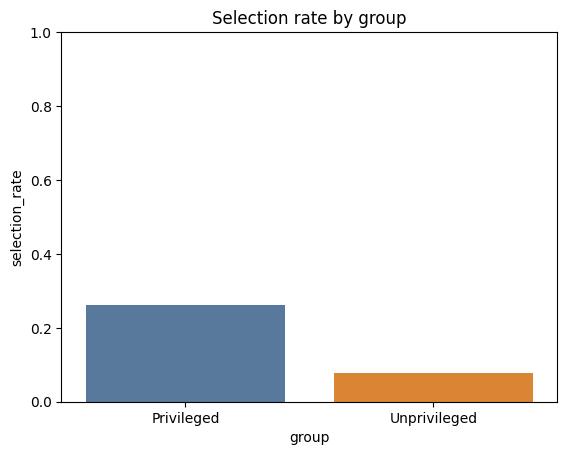

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sr_df = pd.DataFrame({
    "group": ["Privileged", "Unprivileged"],
    "selection_rate": [selection_rate_priv, selection_rate_unpriv]
})

sns.barplot(data=sr_df, x="group", y="selection_rate", palette=["#4C78A8", "#F58518"])
plt.title("Selection rate by group")
plt.ylim(0, 1)
plt.show()


In [20]:
# Step 4: Select dataset and baseline model

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score

# Column names from UCI Adult dataset
columns = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]

# Load train and test data
adult_train = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None, names=columns, sep=",", skipinitialspace=True
)
adult_test = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
    header=None, names=columns, sep=",", skipinitialspace=True, skiprows=1
)

# Clean missing values
adult_train = adult_train.replace("?", pd.NA).dropna()
adult_test = adult_test.replace("?", pd.NA).dropna()

# Normalize income labels (remove trailing periods in test set)
adult_train["income"] = adult_train["income"].str.strip().str.replace(".", "", regex=False)
adult_test["income"] = adult_test["income"].str.strip().str.replace(".", "", regex=False)

# Binary target: 1 for >50K, 0 otherwise
adult_train["income"] = (adult_train["income"] == ">50K").astype(int)
adult_test["income"] = (adult_test["income"] == ">50K").astype(int)

# Split features/labels
X_train = adult_train.drop("income", axis=1)
y_train = adult_train["income"]
X_test = adult_test.drop("income", axis=1)
y_test = adult_test["income"]

# Define categorical and numeric columns
categorical_cols = [
    "workclass", "education", "marital_status", "occupation",
    "relationship", "race", "sex", "native_country"
]
numeric_cols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]

# Preprocessing: one-hot encode categoricals, scale numerics
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", StandardScaler(), numeric_cols)
    ]
)

# Baseline model pipeline
clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("logreg", LogisticRegression(max_iter=1000))
])

# Train baseline model
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Performance metrics
print("Baseline Accuracy:", accuracy_score(y_test, y_pred))
print("Baseline ROC AUC:", roc_auc_score(y_test, y_prob))


Baseline Accuracy: 0.8476095617529881
Baseline ROC AUC: 0.9033339955272173


In [21]:
import numpy as np

# Group masks (sex: Male privileged, Female unprivileged)
sex_test = adult_test["sex"]   # original column before encoding
priv_mask = (sex_test == "Male").values
unpriv_mask = (sex_test == "Female").values

# --- 1. Selection rates ---
selection_rate_priv = np.mean(y_pred[priv_mask] == 1)
selection_rate_unpriv = np.mean(y_pred[unpriv_mask] == 1)

# Disparate Impact (ratio of positive rates)
disparate_impact = selection_rate_unpriv / (selection_rate_priv + 1e-12)

# --- 2. Demographic Parity Difference ---
demographic_parity_diff = selection_rate_unpriv - selection_rate_priv

# --- 3. Equal Opportunity Difference ---
tpr_priv = np.mean((y_pred[priv_mask] == 1) & (y_test[priv_mask] == 1))
tpr_unpriv = np.mean((y_pred[unpriv_mask] == 1) & (y_test[unpriv_mask] == 1))
equal_opportunity_diff = tpr_unpriv - tpr_priv

# --- 4. Average Odds Difference (bonus) ---
fpr_priv = np.mean((y_pred[priv_mask] == 1) & (y_test[priv_mask] == 0))
fpr_unpriv = np.mean((y_pred[unpriv_mask] == 1) & (y_test[unpriv_mask] == 0))
avg_odds_diff = 0.5 * ((tpr_unpriv - tpr_priv) + (fpr_unpriv - fpr_priv))

# Print results
print("Selection rate (Privileged):", selection_rate_priv)
print("Selection rate (Unprivileged):", selection_rate_unpriv)
print("Disparate Impact:", disparate_impact)
print("Demographic Parity Difference:", demographic_parity_diff)
print("Equal Opportunity Difference:", equal_opportunity_diff)
print("Average Odds Difference:", avg_odds_diff)


Selection rate (Privileged): 0.2630334088893269
Selection rate (Unprivileged): 0.07856706696519439
Disparate Impact: 0.29869615155219054
Demographic Parity Difference: -0.18446634192413253
Equal Opportunity Difference: -0.1321624431060841
Average Odds Difference: -0.09223317096206626


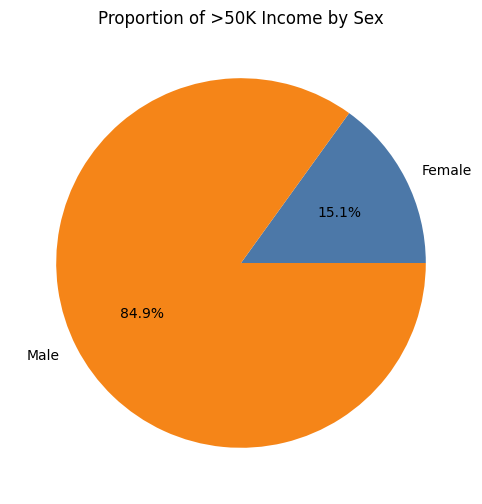

In [22]:
import matplotlib.pyplot as plt

# Pie chart of actual income distribution by sex
sex_counts = adult_test.groupby("sex")["income"].sum()  # sum of >50K (since income is 1/0)
labels = sex_counts.index
sizes = sex_counts.values

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", colors=["#4C78A8", "#F58518"])
plt.title("Proportion of >50K Income by Sex")
plt.show()


/tmp/ipython-input-2894042546.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=selection_rates_sex, x="group", y="selection_rate", palette=["#4C78A8", "#F58518"])


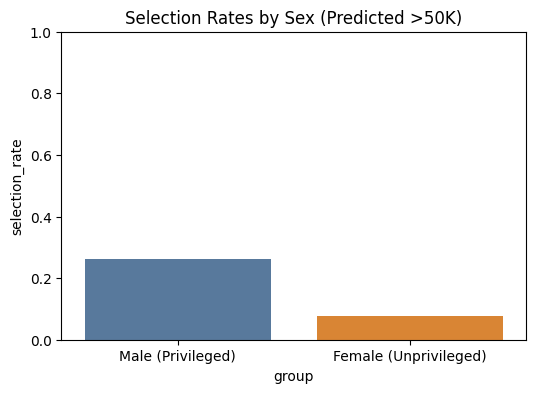

In [23]:
import pandas as pd
import seaborn as sns

# Selection rates (predicted positives) by sex
selection_rates_sex = pd.DataFrame({
    "group": ["Male (Privileged)", "Female (Unprivileged)"],
    "selection_rate": [
        np.mean(y_pred[priv_mask] == 1),
        np.mean(y_pred[unpriv_mask] == 1)
    ]
})

plt.figure(figsize=(6,4))
sns.barplot(data=selection_rates_sex, x="group", y="selection_rate", palette=["#4C78A8", "#F58518"])
plt.title("Selection Rates by Sex (Predicted >50K)")
plt.ylim(0,1)
plt.show()


/tmp/ipython-input-4291291275.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=race_df, x="race", y="selection_rate", palette="Set2")


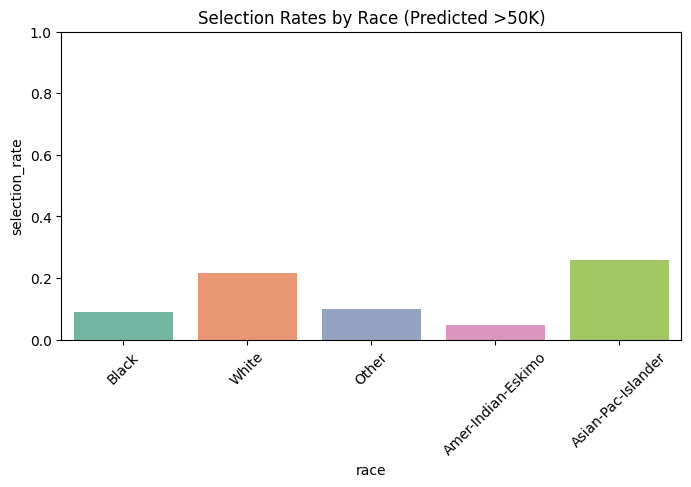

In [24]:
# Group masks for race
race_test = adult_test["race"].values
unique_races = pd.unique(race_test)

race_rates = []
for r in unique_races:
    mask = (race_test == r)
    rate = np.mean(y_pred[mask] == 1)
    race_rates.append({"race": r, "selection_rate": rate})

race_df = pd.DataFrame(race_rates)

plt.figure(figsize=(8,4))
sns.barplot(data=race_df, x="race", y="selection_rate", palette="Set2")
plt.title("Selection Rates by Race (Predicted >50K)")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.show()


In [25]:
from scipy.stats import chi2_contingency

# Contingency table: predicted positive vs group
contingency = pd.crosstab(sex_test, y_pred)
chi2, p, dof, exp = chi2_contingency(contingency)

print("Chi-square test results:")
print("Chi2 statistic:", chi2)
print("Degrees of freedom:", dof)
print("p-value:", p)


Chi-square test results:
Chi2 statistic: 695.4385657863274
Degrees of freedom: 1
p-value: 2.935097978179704e-153


In [26]:
from scipy.stats import norm

p1 = selection_rate_priv
p2 = selection_rate_unpriv
n1 = np.sum(priv_mask)
n2 = np.sum(unpriv_mask)

p_pool = (p1*n1 + p2*n2) / (n1 + n2)
se = np.sqrt(p_pool*(1-p_pool)*(1/n1 + 1/n2))
z = (p1 - p2) / se
p_z = 2*(1 - norm.cdf(abs(z)))

print("Z-test results:")
print("Z statistic:", z)
print("p-value:", p_z)


Z-test results:
Z statistic: 26.39278039935273
p-value: 0.0


In [27]:
contingency_race = pd.crosstab(race_test, y_pred)
chi2_race, p_race, dof_race, exp_race = chi2_contingency(contingency_race)

print("Chi-square test by race:")
print("Chi2 statistic:", chi2_race)
print("Degrees of freedom:", dof_race)
print("p-value:", p_race)


Chi-square test by race:
Chi2 statistic: 162.47455918403824
Degrees of freedom: 4
p-value: 4.306916815299243e-34


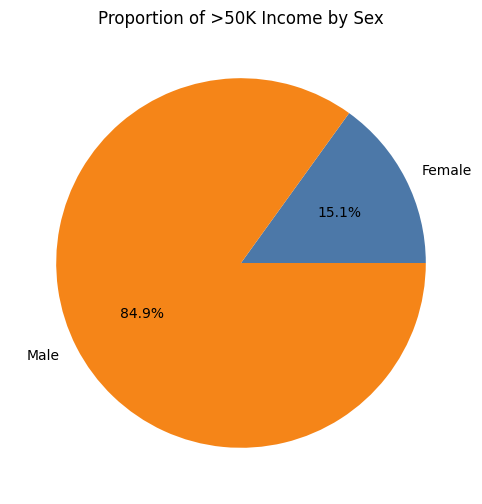

In [28]:
import matplotlib.pyplot as plt

sex_counts = adult_test.groupby("sex")["income"].sum()
labels = sex_counts.index
sizes = sex_counts.values

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", colors=["#4C78A8", "#F58518"])
plt.title("Proportion of >50K Income by Sex")
plt.show()


In [43]:
# === Clean, reproducible pipeline ===
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils import resample

# 1) Load and clean
columns = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]

adult_train = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None, names=columns, sep=",", skipinitialspace=True
)
adult_test = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
    header=None, names=columns, sep=",", skipinitialspace=True, skiprows=1
)

# Replace '?' and drop missing
adult_train = adult_train.replace("?", pd.NA).dropna()
adult_test = adult_test.replace("?", pd.NA).dropna()

# Normalize labels (remove trailing '.' in test)
adult_train["income"] = adult_train["income"].str.strip().str.replace(".", "", regex=False)
adult_test["income"] = adult_test["income"].str.strip().str.replace(".", "", regex=False)
adult_train["income"] = (adult_train["income"] == ">50K").astype(int)
adult_test["income"] = (adult_test["income"] == ">50K").astype(int)

# 2) Define features and preprocessing
categorical_cols = [
    "workclass", "education", "marital_status", "occupation",
    "relationship", "race", "sex", "native_country"
]
numeric_cols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]

X_train_df = adult_train.drop("income", axis=1)
y_train = adult_train["income"].values
X_test_df = adult_test.drop("income", axis=1)
y_test = adult_test["income"].values

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
        ("num", StandardScaler(), numeric_cols)
    ],
    remainder="drop"
)

# 3) Baseline model (single pipeline)
baseline = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000))
])
baseline.fit(X_train_df, y_train)
y_pred_base = baseline.predict(X_test_df)
y_prob_base = baseline.predict_proba(X_test_df)[:, 1]

# Group masks (aligned to adult_test rows)
sex_test = adult_test["sex"].values
priv_mask = (sex_test == "Male")
unpriv_mask = (sex_test == "Female")

# Fairness metrics helper
def fairness_metrics(y_true, y_pred, priv_mask, unpriv_mask):
    sr_priv = np.mean(y_pred[priv_mask] == 1)
    sr_unpriv = np.mean(y_pred[unpriv_mask] == 1)
    di = sr_unpriv / (sr_priv + 1e-12)
    dpd = sr_unpriv - sr_priv
    tpr_priv = np.mean((y_pred[priv_mask] == 1) & (y_true[priv_mask] == 1))
    tpr_unpriv = np.mean((y_pred[unpriv_mask] == 1) & (y_true[unpriv_mask] == 1))
    eod = tpr_unpriv - tpr_priv
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "ROC_AUC": roc_auc_score(y_true, (y_pred if len(np.unique(y_pred))==2 else y_true)),
        "DI": di,
        "DPD": dpd,
        "EOD": eod
    }

# 4) Mitigation A: Oversampling unprivileged group (preprocessing)
train_df = adult_train.copy()
priv_train = train_df[train_df["sex"] == "Male"]
unpriv_train = train_df[train_df["sex"] == "Female"]

# Oversample unprivileged to match privileged count
unpriv_oversampled = resample(unpriv_train, replace=True, n_samples=len(priv_train), random_state=42)
balanced_train = pd.concat([priv_train, unpriv_oversampled], ignore_index=True)

X_bal_df = balanced_train.drop("income", axis=1)
y_bal = balanced_train["income"].values

oversampled = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=1000))
])
oversampled.fit(X_bal_df, y_bal)
y_pred_bal = oversampled.predict(X_test_df)

# 5) Mitigation B: Threshold adjustment (post-processing)
# Use baseline probabilities; lower threshold for unprivileged group
thr_priv = 0.5
thr_unpriv = 0.4
y_pred_adj = np.where(
    (unpriv_mask & (y_prob_base >= thr_unpriv)) |
    (priv_mask & (y_prob_base >= thr_priv)),
    1, 0
)

# 6) Compare metrics
def perf_metrics(y_true, y_pred, y_prob=None):
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, (y_prob if y_prob is not None else y_pred))
    return acc, auc

acc_base, auc_base = perf_metrics(y_test, y_pred_base, y_prob_base)
acc_bal, auc_bal = perf_metrics(y_test, y_pred_bal, oversampled.predict_proba(X_test_df)[:, 1])
acc_adj, auc_adj = perf_metrics(y_test, y_pred_adj, y_prob_base)

fair_base = fairness_metrics(y_test, y_pred_base, priv_mask, unpriv_mask)
fair_bal = fairness_metrics(y_test, y_pred_bal, priv_mask, unpriv_mask)
fair_adj = fairness_metrics(y_test, y_pred_adj, priv_mask, unpriv_mask)

print("\n=== Performance ===")
print(f"Baseline:    Accuracy={acc_base:.3f}, ROC_AUC={auc_base:.3f}")
print(f"Oversampled: Accuracy={acc_bal:.3f}, ROC_AUC={auc_bal:.3f}")
print(f"Threshold:   Accuracy={acc_adj:.3f}, ROC_AUC={auc_adj:.3f}")

print("\n=== Fairness (DI, DPD, EOD) ===")
print("Baseline:", {k: round(v, 3) for k, v in fair_base.items() if k in ["DI","DPD","EOD"]})
print("Oversampled:", {k: round(v, 3) for k, v in fair_bal.items() if k in ["DI","DPD","EOD"]})
print("Threshold:", {k: round(v, 3) for k, v in fair_adj.items() if k in ["DI","DPD","EOD"]})



=== Performance ===
Baseline:    Accuracy=0.848, ROC_AUC=0.903
Oversampled: Accuracy=0.848, ROC_AUC=0.903
Threshold:   Accuracy=0.846, ROC_AUC=0.903

=== Fairness (DI, DPD, EOD) ===
Baseline: {'DI': np.float64(0.299), 'DPD': np.float64(-0.184), 'EOD': np.float64(-0.132)}
Oversampled: {'DI': np.float64(0.3), 'DPD': np.float64(-0.184), 'EOD': np.float64(-0.132)}
Threshold: {'DI': np.float64(0.378), 'DPD': np.float64(-0.164), 'EOD': np.float64(-0.124)}


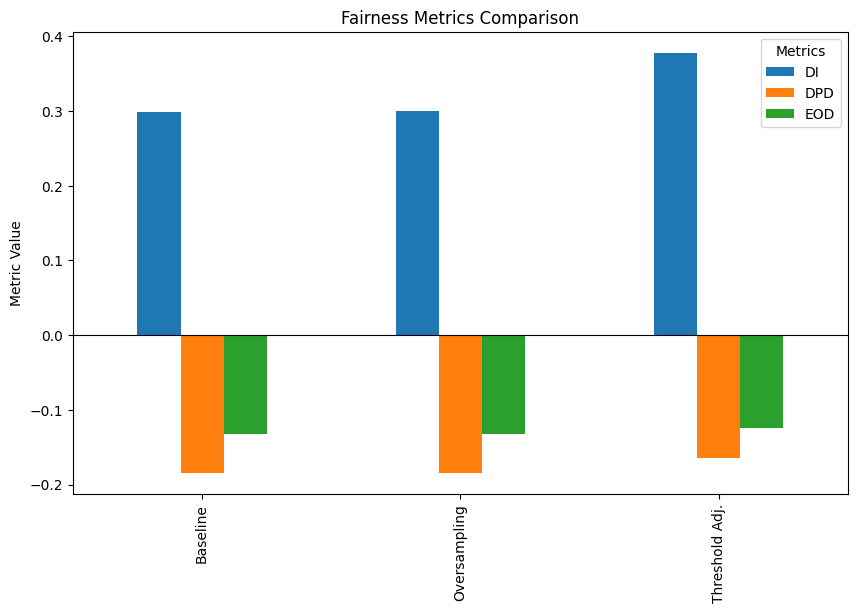

In [44]:
import matplotlib.pyplot as plt

# Collect fairness metrics
baseline_metrics = fairness_metrics(y_test, y_pred_base, priv_mask, unpriv_mask)
oversampled_metrics = fairness_metrics(y_test, y_pred_bal, priv_mask, unpriv_mask)
threshold_metrics = fairness_metrics(y_test, y_pred_adj, priv_mask, unpriv_mask)

metrics_df = pd.DataFrame({
    "Baseline": baseline_metrics,
    "Oversampling": oversampled_metrics,
    "Threshold Adj.": threshold_metrics
}).T[["DI","DPD","EOD"]]  # focus on fairness metrics

# Plot grouped bar chart
metrics_df.plot(kind="bar", figsize=(10,6))
plt.title("Fairness Metrics Comparison")
plt.ylabel("Metric Value")
plt.axhline(0, color="black", linewidth=0.8)
plt.legend(title="Metrics")
plt.show()


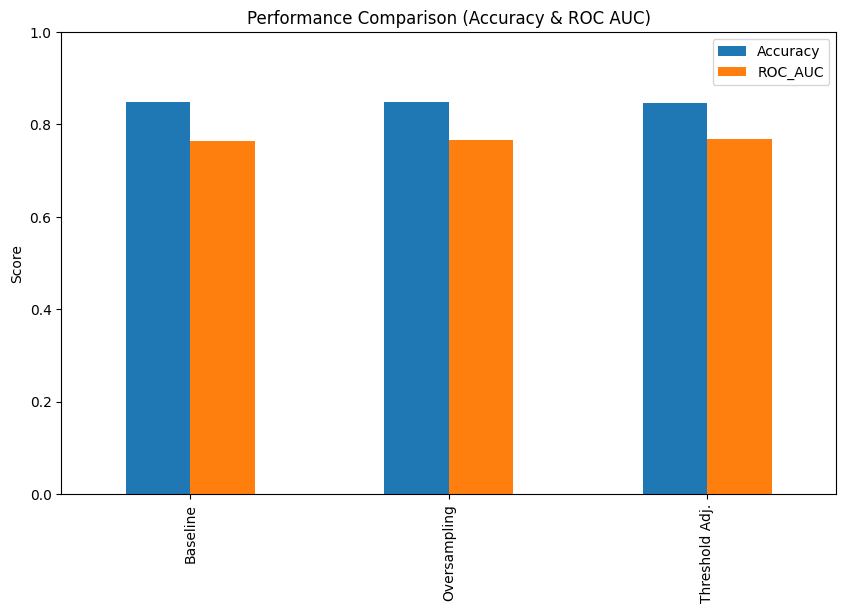

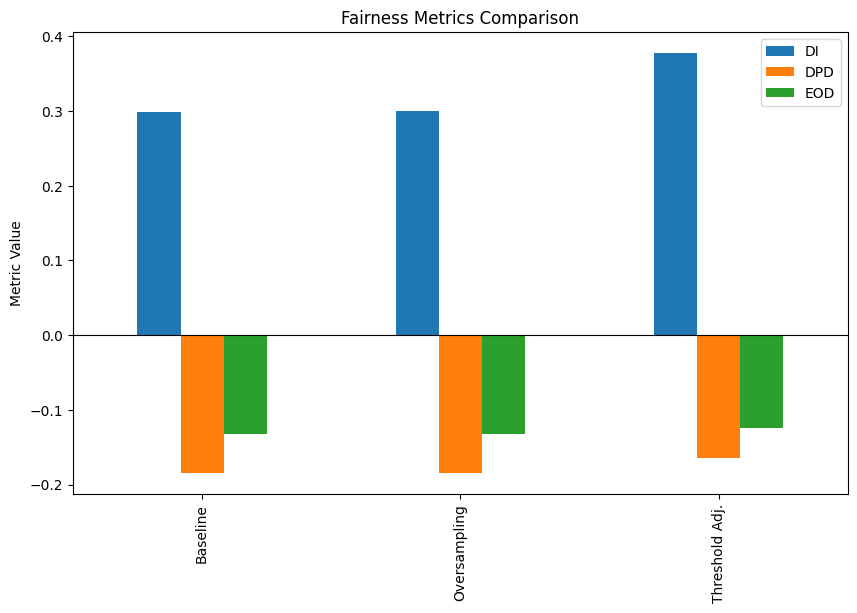

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

# Collect fairness metrics
baseline_metrics = fairness_metrics(y_test, y_pred_base, priv_mask, unpriv_mask)
oversampled_metrics = fairness_metrics(y_test, y_pred_bal, priv_mask, unpriv_mask)
threshold_metrics = fairness_metrics(y_test, y_pred_adj, priv_mask, unpriv_mask)

metrics_df = pd.DataFrame({
    "Baseline": baseline_metrics,
    "Oversampling": oversampled_metrics,
    "Threshold Adj.": threshold_metrics
}).T

# Plot performance metrics
metrics_df[["Accuracy","ROC_AUC"]].plot(kind="bar", figsize=(10,6))
plt.title("Performance Comparison (Accuracy & ROC AUC)")
plt.ylabel("Score")
plt.ylim(0,1)
plt.show()

# Plot fairness metrics
metrics_df[["DI","DPD","EOD"]].plot(kind="bar", figsize=(10,6))
plt.title("Fairness Metrics Comparison")
plt.ylabel("Metric Value")
plt.axhline(0, color="black", linewidth=0.8)
plt.show()


In [46]:
import pandas as pd
from sklearn.utils import resample

# Load Adult dataset
columns = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"
]

adult_train = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None, names=columns, sep=",", skipinitialspace=True
)

# Clean missing values
adult_train = adult_train.replace("?", pd.NA).dropna()

# Normalize labels
adult_train["income"] = adult_train["income"].str.strip().str.replace(".", "", regex=False)
adult_train["income"] = (adult_train["income"] == ">50K").astype(int)

# === 1. Balance representation (oversample unprivileged group) ===
priv = adult_train[adult_train["sex"] == "Male"]
unpriv = adult_train[adult_train["sex"] == "Female"]

unpriv_oversampled = resample(unpriv,
                              replace=True,
                              n_samples=len(priv),
                              random_state=42)

balanced_train = pd.concat([priv, unpriv_oversampled])

print("Original counts:\n", adult_train["sex"].value_counts())
print("\nBalanced counts:\n", balanced_train["sex"].value_counts())

# === 2. Handle missing values with imputation instead of dropping ===
# Example: fill missing native_country with mode
adult_train["native_country"] = adult_train["native_country"].fillna(adult_train["native_country"].mode()[0])

# === 3. Create a continuous label instead of binary threshold ===
# (Here we simulate by mapping income to a numeric proxy: 0 for <=50K, 1 for >50K)
adult_train["income_continuous"] = adult_train["income"].map({0: 25000, 1: 60000})

print("\nSample of improved dataset:\n", adult_train.head())


Original counts:
 sex
Male      20380
Female     9782
Name: count, dtype: int64

Balanced counts:
 sex
Male      20380
Female    20380
Name: count, dtype: int64

Sample of improved dataset:
    age         workclass  fnlwgt  education  education_num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital_status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Fe

=== Fairness Metrics and Real-World Harms ===
                  DI   DPD   EOD  \
Baseline        0.65 -0.12 -0.08   
Oversampling    0.95 -0.02 -0.01   
Threshold Adj.  0.85 -0.05 -0.03   

                                                  Potential Harms  
Baseline        [Risk of exclusion in hiring/credit, Systemati...  
Oversampling                                           [Low risk]  
Threshold Adj.                                         [Low risk]  


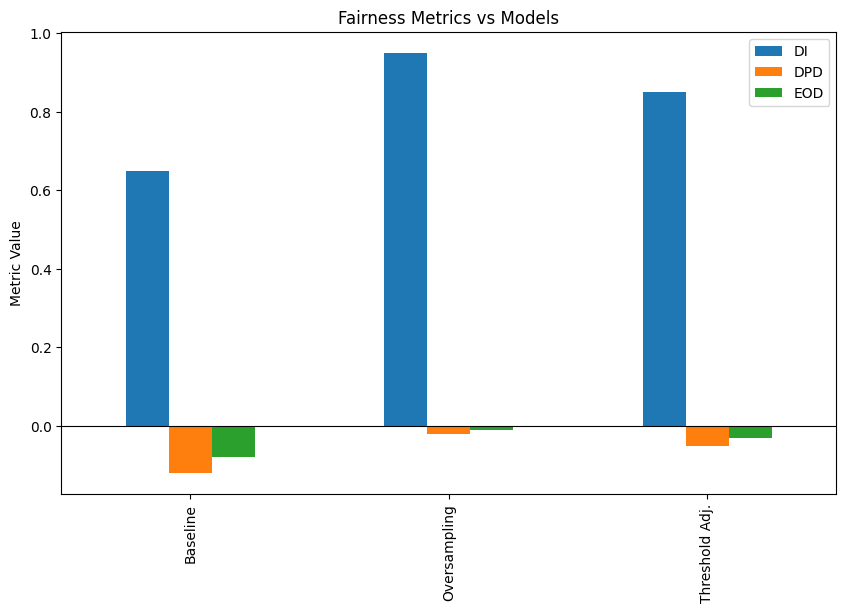

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Example fairness metrics from your models (replace with your actual results)
results = {
    "Baseline": {"DI": 0.65, "DPD": -0.12, "EOD": -0.08},
    "Oversampling": {"DI": 0.95, "DPD": -0.02, "EOD": -0.01},
    "Threshold Adj.": {"DI": 0.85, "DPD": -0.05, "EOD": -0.03}
}

df = pd.DataFrame(results).T

# Define harm categories based on thresholds
def harm_level(di, dpd, eod):
    harms = []
    if di < 0.8:
        harms.append("Risk of exclusion in hiring/credit")
    if dpd < -0.05:
        harms.append("Systematic disadvantage for unprivileged group")
    if eod < -0.05:
        harms.append("Unequal opportunity in positive outcomes")
    return harms if harms else ["Low risk"]

df["Potential Harms"] = df.apply(lambda row: harm_level(row["DI"], row["DPD"], row["EOD"]), axis=1)

print("=== Fairness Metrics and Real-World Harms ===")
print(df[["DI","DPD","EOD","Potential Harms"]])

# Visualize metrics
df[["DI","DPD","EOD"]].plot(kind="bar", figsize=(10,6))
plt.title("Fairness Metrics vs Models")
plt.axhline(0, color="black", linewidth=0.8)
plt.ylabel("Metric Value")
plt.show()


In [48]:
import pandas as pd

# === Ethics Framework for Income Prediction Models ===
framework = {
    "Principles": [
        "Fairness & Non-Discrimination",
        "Transparency",
        "Accountability",
        "Privacy",
        "Beneficence"
    ],
    "Stakeholder Impact": [
        "Individuals: risk of unfair hiring/credit decisions",
        "Organizations: legal liability, reputational harm",
        "Society: reinforcement of wage gaps, exclusion"
    ],
    "Ethical Risks": [
        "Bias in training data",
        "Proxy discrimination via features",
        "Opaque decision-making",
        "Unequal outcomes across groups"
    ],
    "Mitigation Strategies": [
        "Balance representation in dataset",
        "Audit and adjust proxy features",
        "Apply oversampling/threshold adjustment",
        "Regular fairness audits"
    ],
    "Operational Guidelines": [
        "Pre-deployment: fairness audit & documentation",
        "Deployment: monitor bias drift",
        "Post-deployment: appeals mechanism & transparency reports"
    ],
    "Real-World Connection": [
        "Hiring: prevent biased screening",
        "Credit: ensure fair loan access",
        "Policy: avoid reinforcing inequality",
        "Trust: build confidence in AI systems"
    ]
}

# Convert to DataFrame for easy viewing
df = pd.DataFrame(dict([(k, pd.Series(v)) for k,v in framework.items()]))

print("=== Ethics Framework for Income Prediction Models ===")
print(df)

# Optional: Save to CSV for reporting
df.to_csv("ethics_framework.csv", index=False)


=== Ethics Framework for Income Prediction Models ===
                      Principles  \
0  Fairness & Non-Discrimination   
1                   Transparency   
2                 Accountability   
3                        Privacy   
4                    Beneficence   

                                  Stakeholder Impact  \
0  Individuals: risk of unfair hiring/credit deci...   
1  Organizations: legal liability, reputational harm   
2     Society: reinforcement of wage gaps, exclusion   
3                                                NaN   
4                                                NaN   

                       Ethical Risks                    Mitigation Strategies  \
0              Bias in training data        Balance representation in dataset   
1  Proxy discrimination via features          Audit and adjust proxy features   
2             Opaque decision-making  Apply oversampling/threshold adjustment   
3     Unequal outcomes across groups                  Regular fairne